In [3]:
import numpy as np
from seaborn import color_palette
from skimage import io
import re
import pandas as pd
import seaborn as sns
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt
from pathlib import Path
import json
from copy import copy
from pprint import pprint

In [10]:
def get_image(configfile, stem):
    with open(configfile) as f:
        config = json.load(f)
        
        for exp in config['experiments']:
            for img in exp['images']:
                if img['stem'] == stem:
                    print(f"{img['stem']}: {img['segment']} {img['detect_spots']}")
                    return img


In [199]:
# bad picture
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/config-detection-processed.json'
stem = 'exp22-GAL_07' 

img = get_image(configfile, stem)

exp22-GAL_07: True True


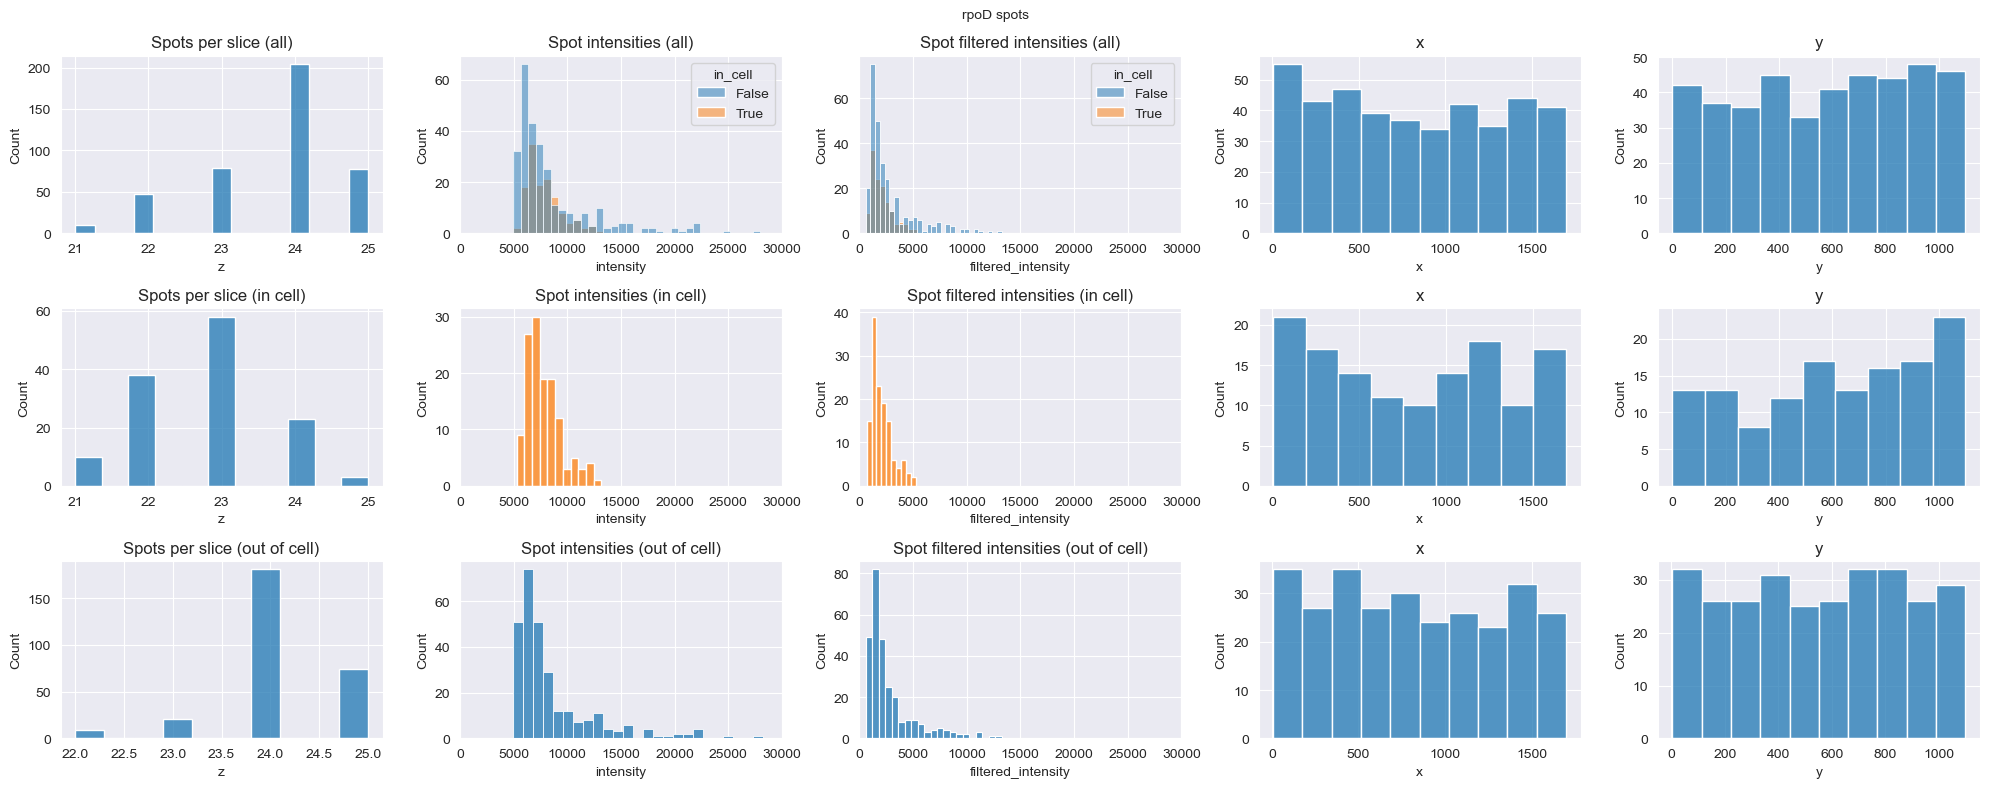

In [200]:
# rpoD
mrna = 'rpoD'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 30000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


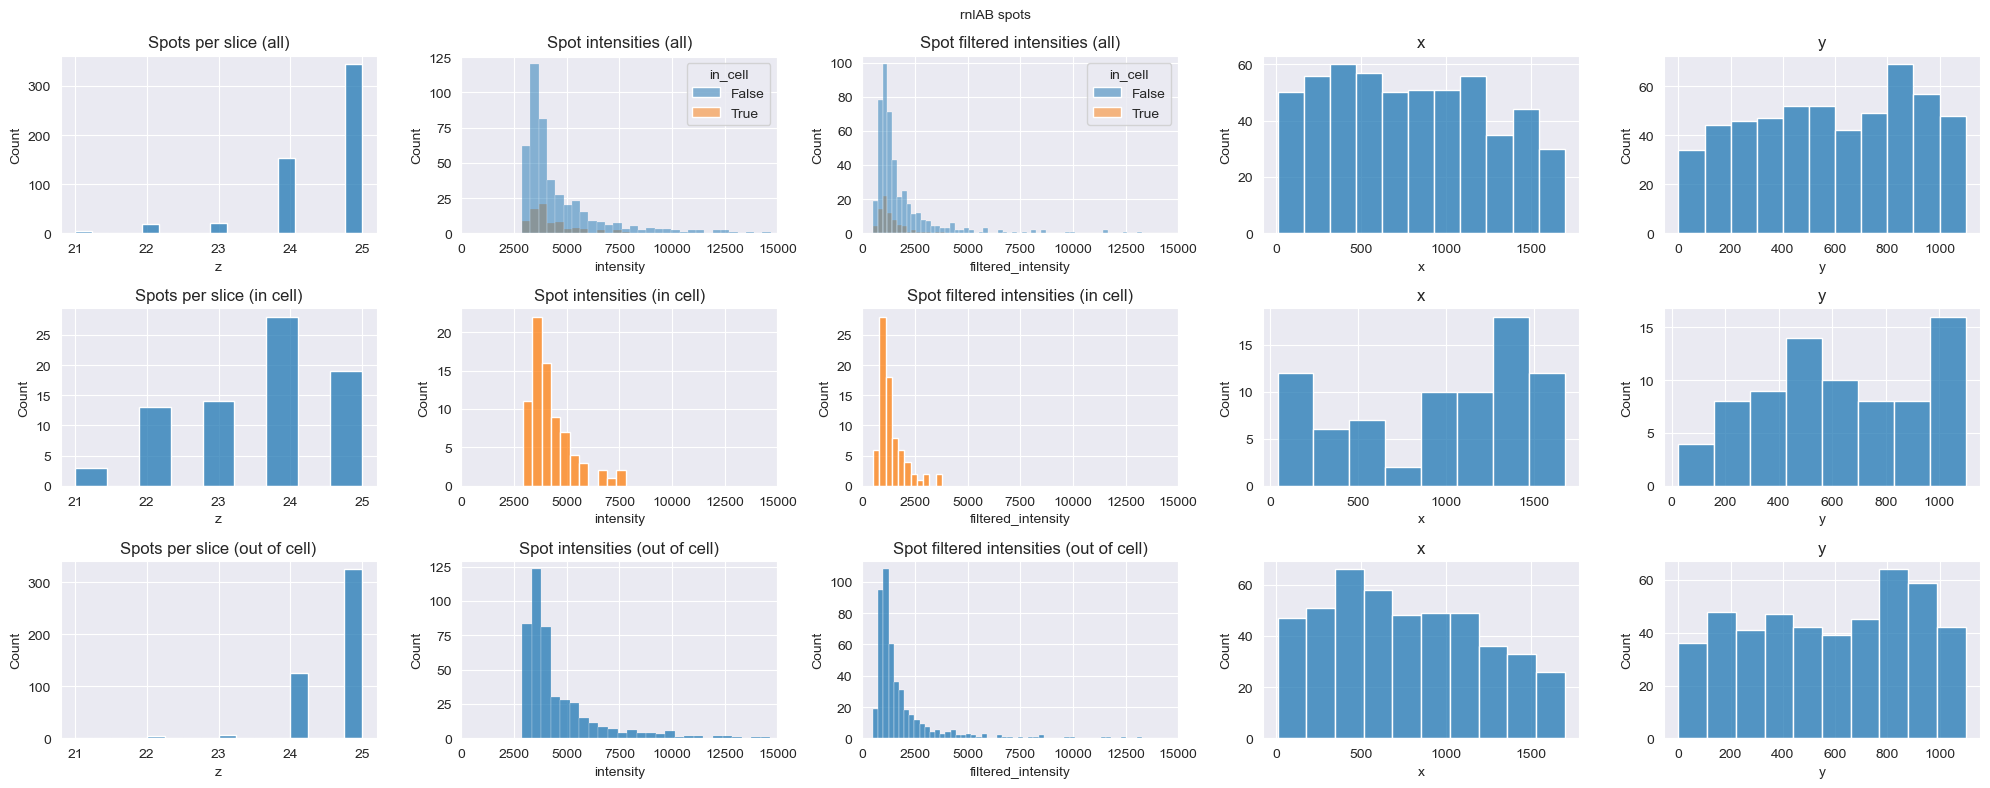

In [202]:
# rnlAB
mrna = 'rnlAB'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


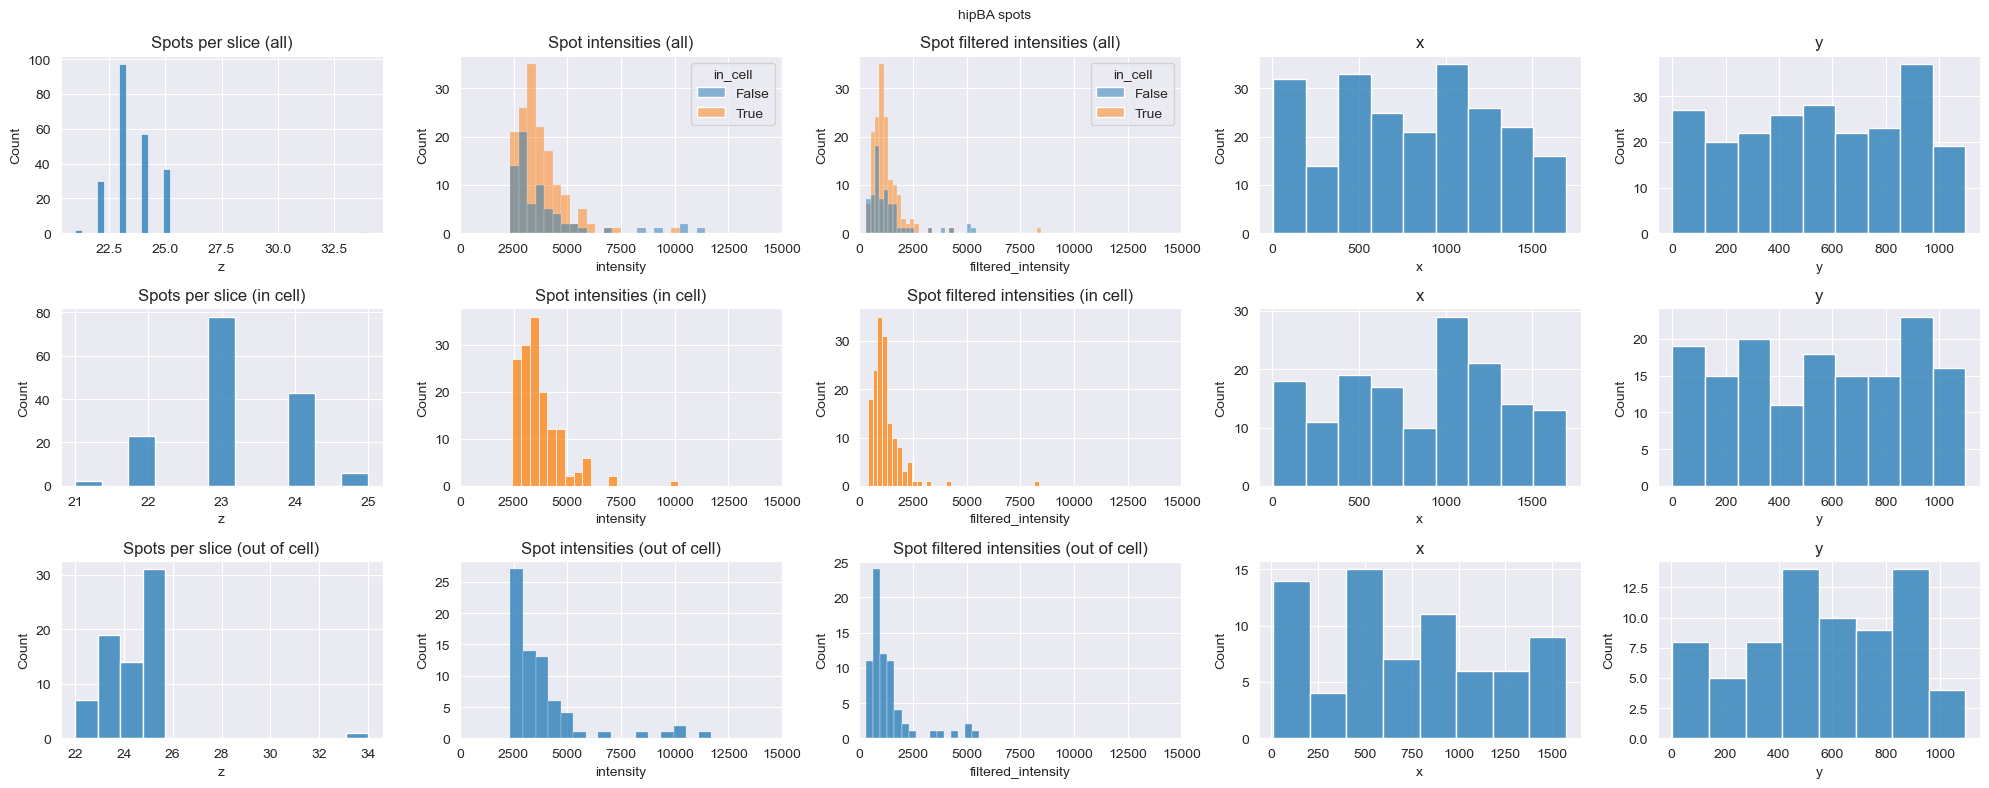

In [203]:
# hipBA
mrna = 'hipBA'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


In [184]:
# good picture (good signal but segmentation leaves legit cells out)
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/config-detection-processed.json'
stem = 'exp22-GLU_02'  

img = get_image(configfile, stem)

exp22-GLU_02: True True


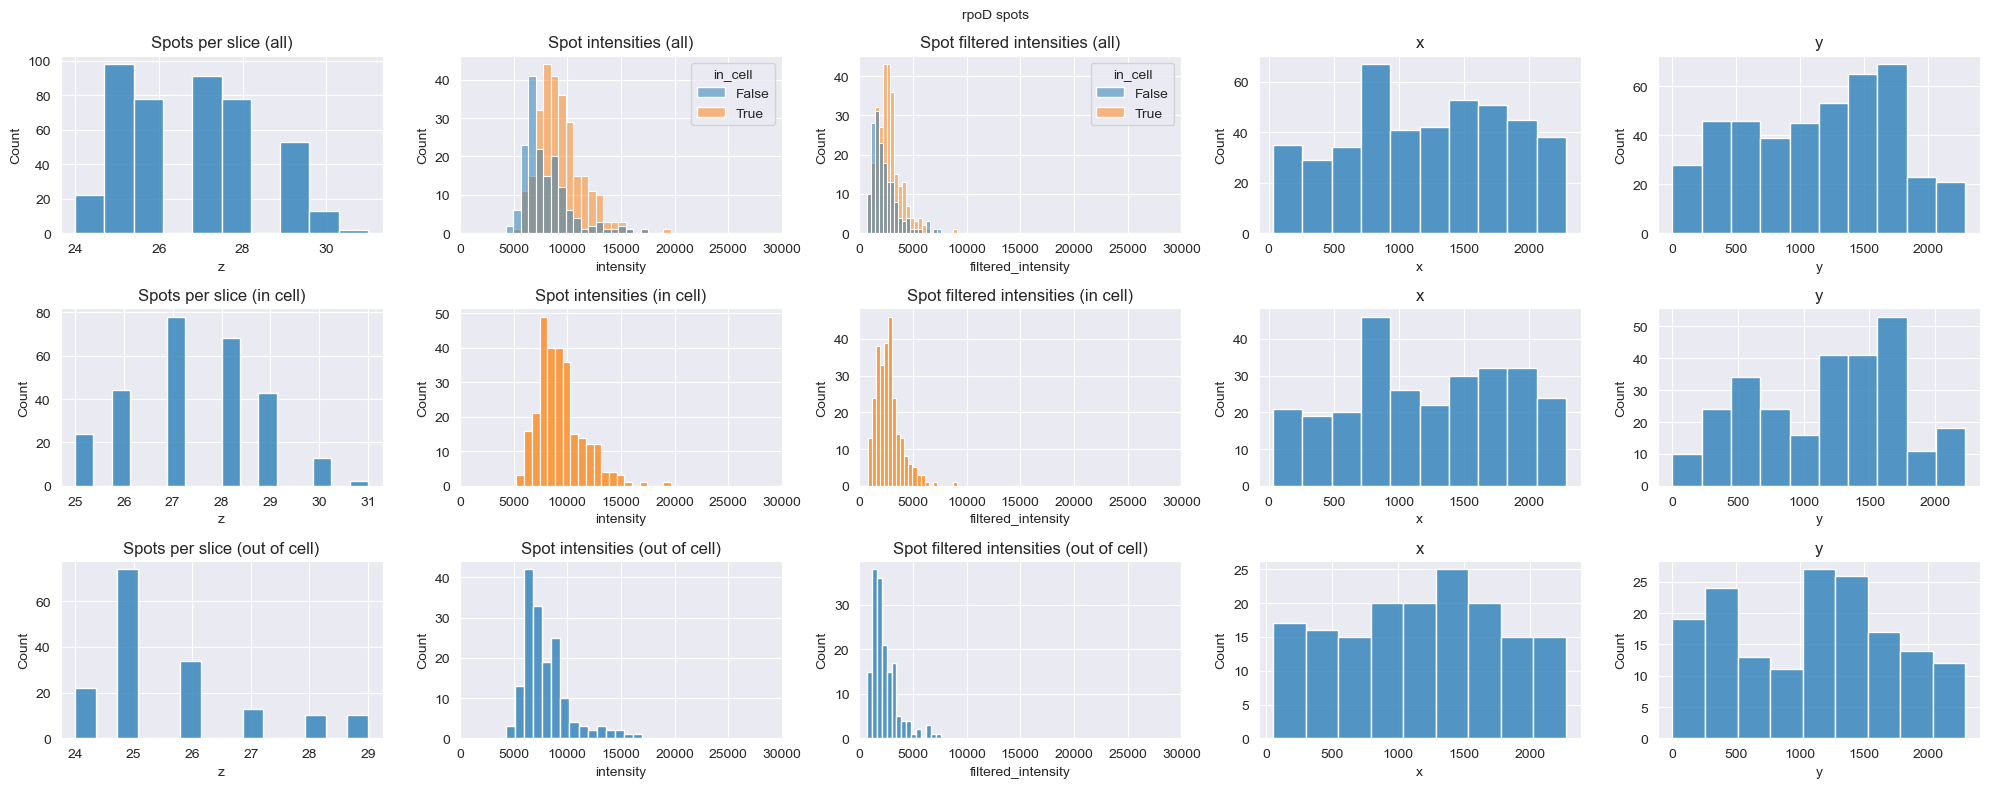

In [185]:
# rpoD
mrna = 'rpoD'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 30000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


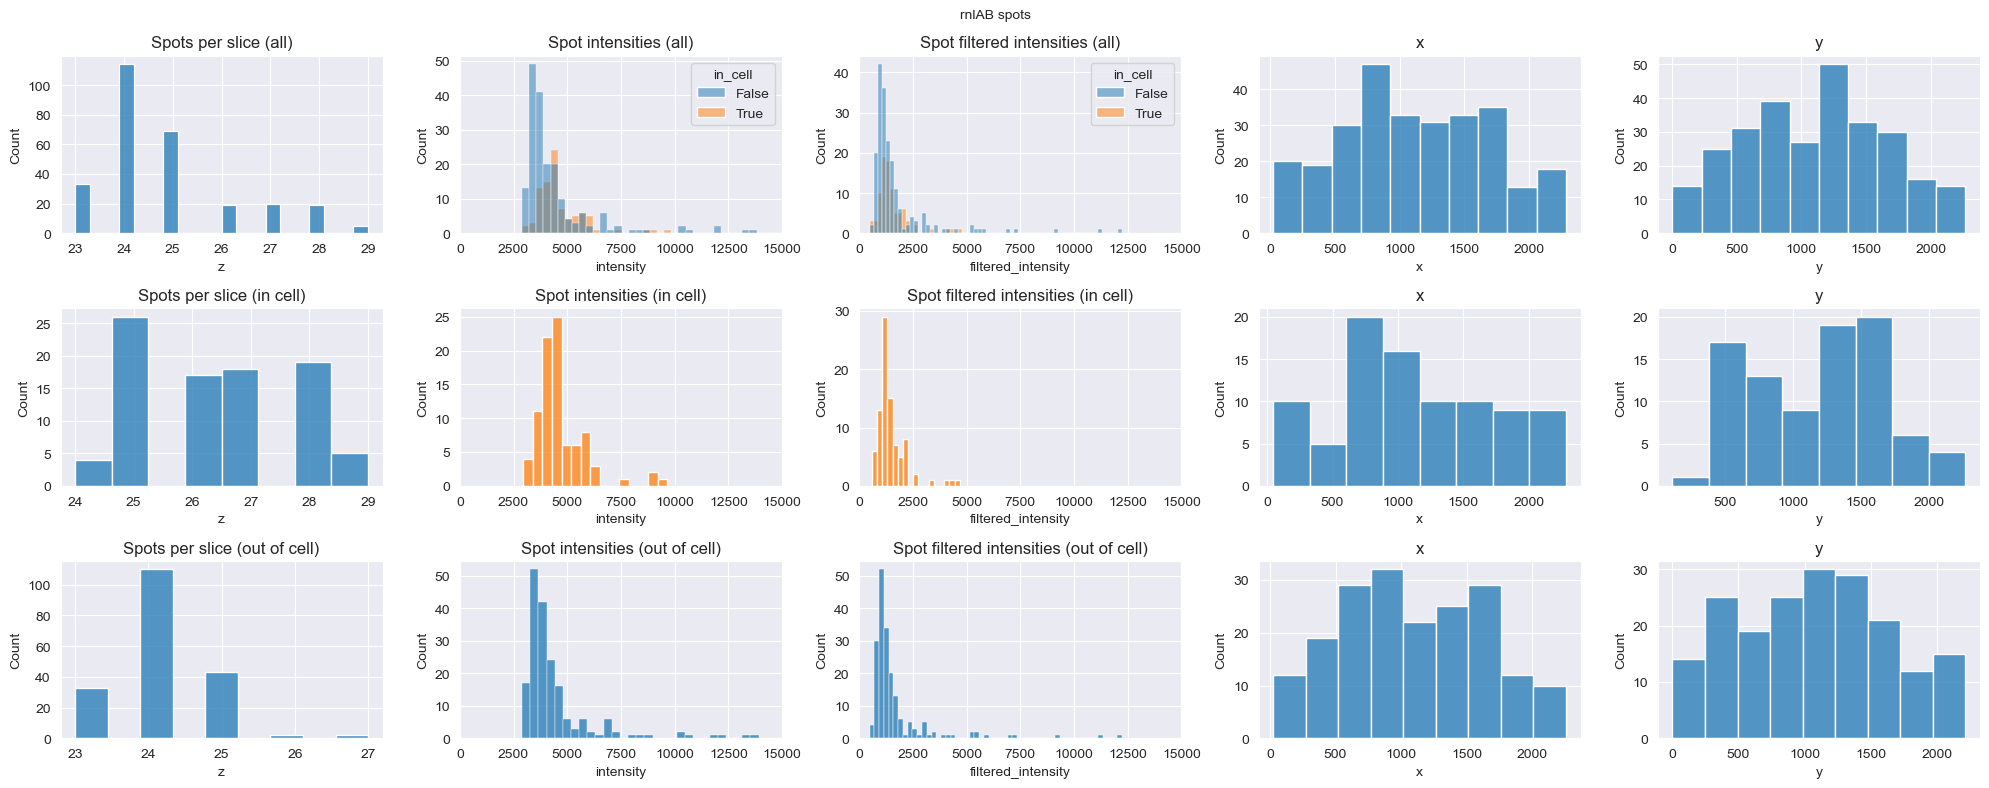

In [186]:
# rnlAB
mrna = 'rnlAB'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


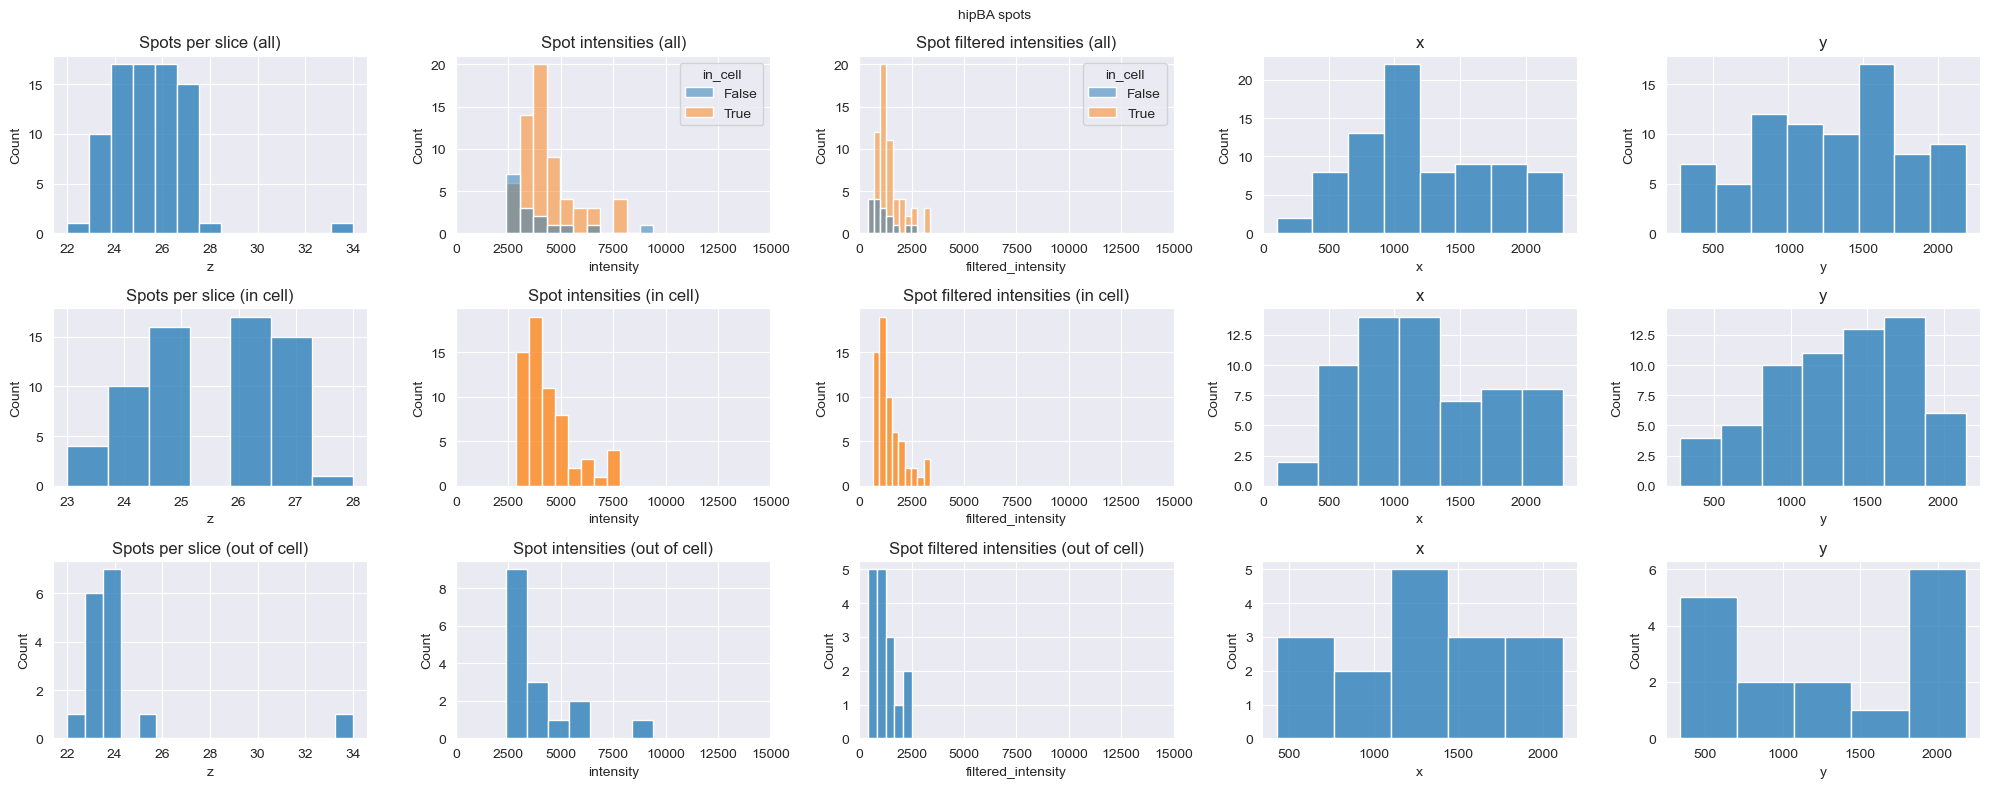

In [187]:
# hipBA
mrna = 'hipBA'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


In [99]:
# even better picture (good signal and good segmentation)
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20240927-exp16/config-detection-processed.json'
stem = 'MG1655_GLU_OD_0.3_left_02'  

img = get_image(configfile, stem)


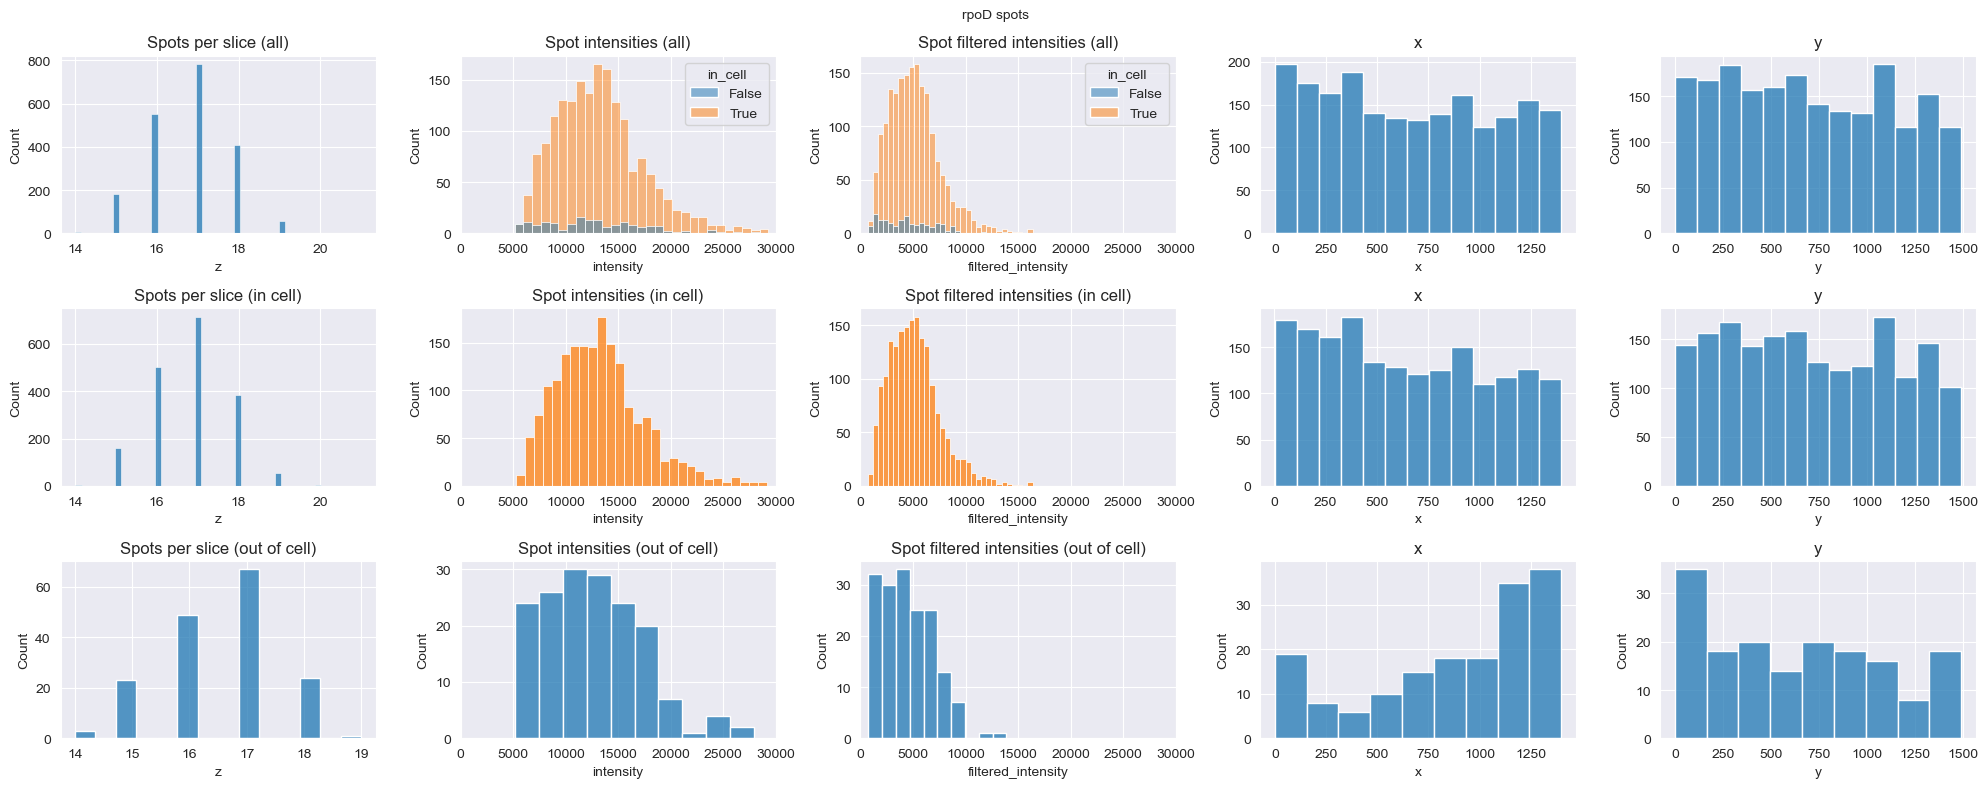

In [168]:
# rpoD
mrna = 'rpoD'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 30000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


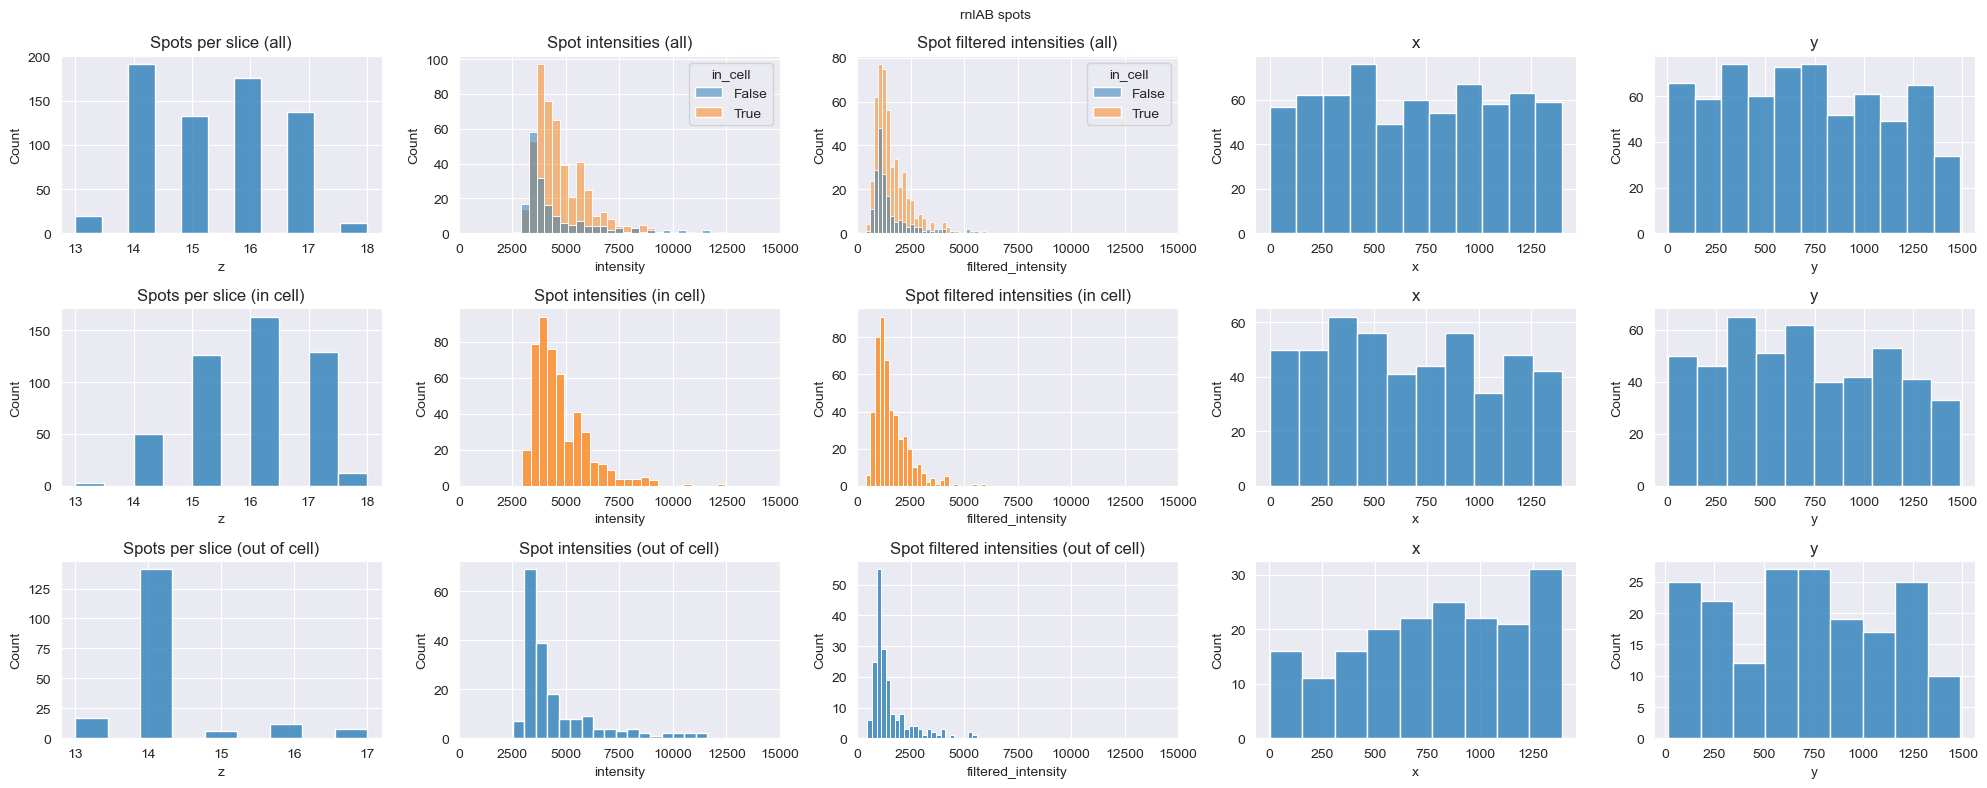

In [169]:
# rnlAB
mrna = 'rnlAB'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


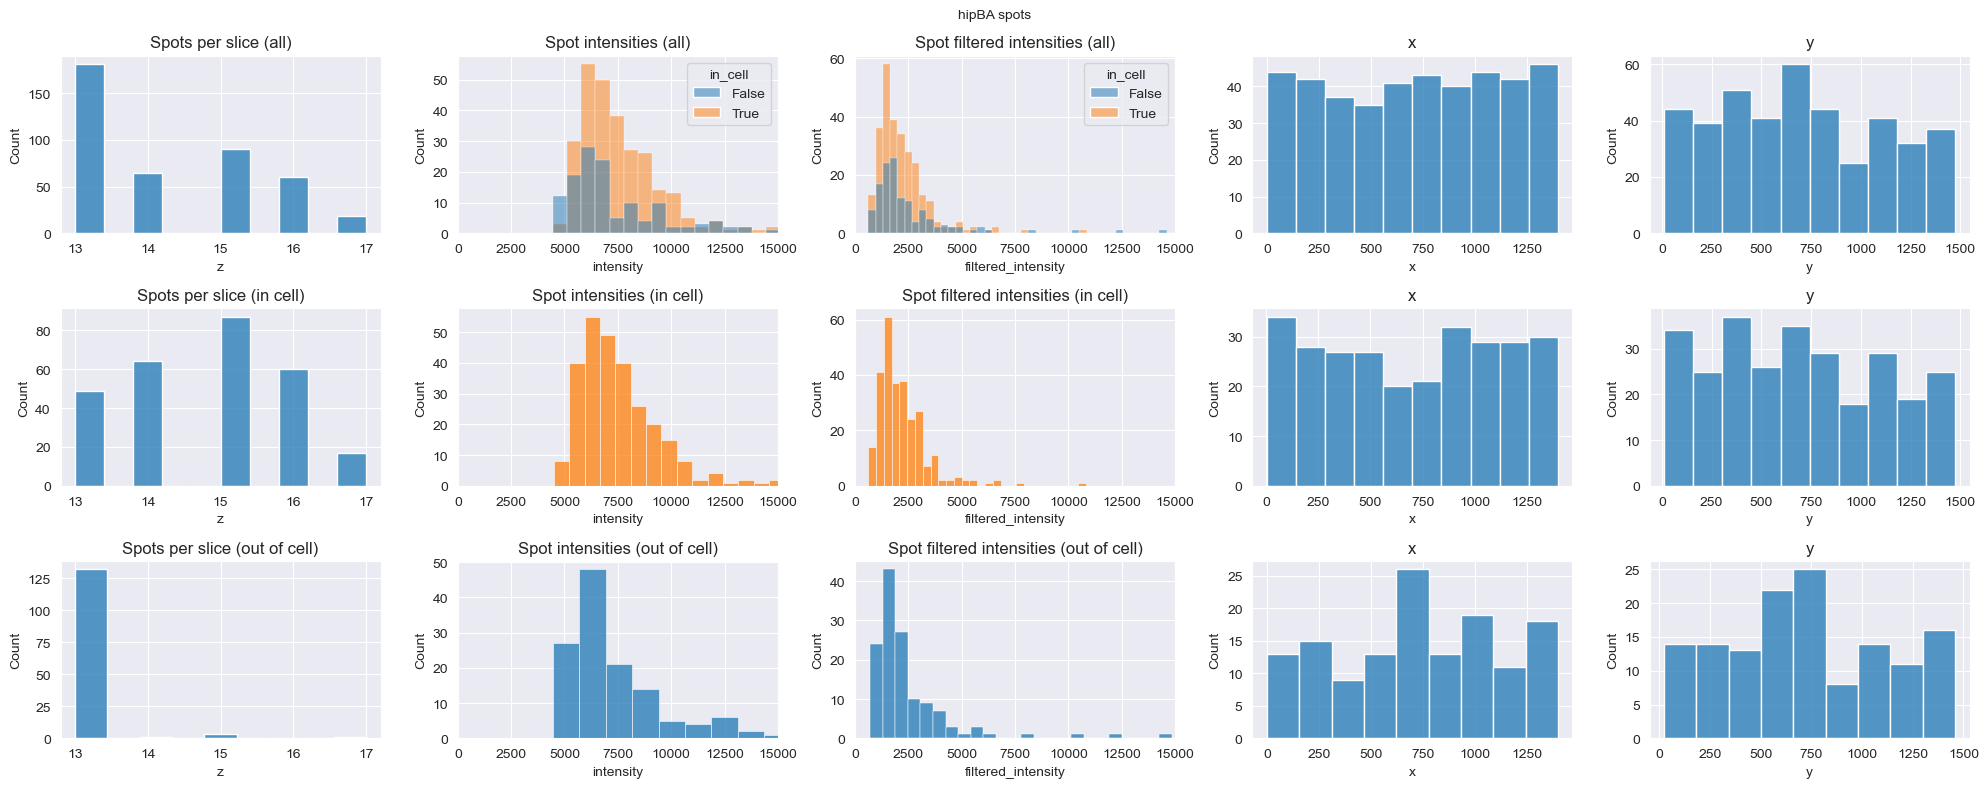

In [170]:
# hipBA
mrna = 'hipBA'
spots = pd.DataFrame(np.load(img[mrna]['spotsfile']), columns=['z', 'y', 'x', 'intensity', 'filtered_intensity', 'label'])
spots['in_cell'] = spots.apply(lambda s: False if s['label'] == 0 else True, axis=1)

fig, ax = plt.subplots(3, 5, figsize=(20, 8))
xmax = 15000
sns.histplot(spots, x='z', ax=ax[0][0]).set(title='Spots per slice (all)')
sns.histplot(spots, x='intensity', hue='in_cell', ax=ax[0][1]).set(title='Spot intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='filtered_intensity', hue='in_cell', ax=ax[0][2]).set(title='Spot filtered intensities (all)', xlim=(0, xmax))
sns.histplot(spots, x='x', ax=ax[0][3]).set(title='x')
sns.histplot(spots, x='y', ax=ax[0][4]).set(title='y')

sns.histplot(spots.query('label > 0'), x='z', ax=ax[1][0]).set(title='Spots per slice (in cell)')
sns.histplot(spots.query('label > 0'), x='intensity', color=sns.color_palette()[1], ax=ax[1][1]).set(title='Spot intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='filtered_intensity', color=sns.color_palette()[1], ax=ax[1][2]).set(title='Spot filtered intensities (in cell)', xlim=(0, xmax))
sns.histplot(spots.query('label > 0'), x='x', ax=ax[1][3]).set(title='x')
sns.histplot(spots.query('label > 0'), x='y', ax=ax[1][4]).set(title='y')

sns.histplot(spots.query('label == 0'), x='z', ax=ax[2][0]).set(title='Spots per slice (out of cell)')
sns.histplot(spots.query('label == 0'), x='intensity', color=sns.color_palette()[0], ax=ax[2][1]).set(title='Spot intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='filtered_intensity', color=sns.color_palette()[0], ax=ax[2][2]).set(title='Spot filtered intensities (out of cell)', xlim=(0, xmax))
sns.histplot(spots.query('label == 0'), x='x', ax=ax[2][3]).set(title='x')
sns.histplot(spots.query('label == 0'), x='y', ax=ax[2][4]).set(title='y')

fig.suptitle(f'{mrna} spots', fontsize=10)

plt.tight_layout();


#### The above does not work very well, because:
1. The intensities of the cells that don't have a mask despite being legitimate cells 
count as out-of-cells intensities.
2. Where the DIC is misaligned (top right corner), spots can be erroneously counted as out of cell because they are just outside of the mask.

In [204]:
# good picture (good signal but segmentation leaves legit cells out)
mrna = 'rpoD'
configfile = '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/config-detection-processed.json'
stem = 'exp22-GLU_02'

img = get_image(configfile, stem)

exp22-GLU_02: True True


In [206]:
img['rpoD']

{'rnafile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD.tif',
 'z_max_focus': 28,
 'ifx_1': 19,
 'ifx_2': 42,
 'filteredmrnafile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_filtered.npy',
 'zprojectmrnafile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_zproject.npy',
 'filteredpaddedmrnafile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_filtered_padded.npy',
 'spot_detection_threshold': 50,
 'number_of_spots': 436,
 'spotsfile_latest': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_spots_thr=50_ifx1=19_ifx2=42.npy',
 'spotsfile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_spots.npy',
 'decompspotsfile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_decomposed_spots.npy',
 'ddregionsfile': '/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/r

In [210]:
spots = np.load('/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_spots.npy')
decomp_spots = np.load('/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_decomposed_spots.npy')
dense_regions = np.load('/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_ddregions.npy')
refspot = io.imread('/Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp22/exp22-GLU_02/rpoD_rf_spots.tif')

In [213]:
spots.shape, decomp_spots.shape, dense_regions.shape


((436, 6), (488, 3), (23, 7))

In [209]:
spots

array([[   24,    12,   539, 15935,  7593,     0],
       [   24,    72,   269,  6576,  1933,     0],
       [   24,   130,   166,  9212,  3413,     0],
       ...,
       [   30,  2210,  1925,  7800,  2495,   161],
       [   31,  1123,  2254,  7201,  1917,    68],
       [   31,  2049,  1866, 10301,  4039,   150]])

In [216]:
decomp_spots

array([[  24,   72,  269],
       [  24,  130,  166],
       [  24,  143,  911],
       ...,
       [  29, 2113, 1162],
       [  28, 2113, 1163],
       [  30, 2114, 1162]])

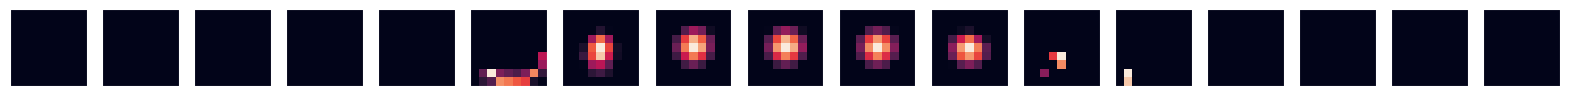

In [215]:
fig,axis=plt.subplots(ncols=refspot.shape[0],figsize=(20,10))

for i,ax in zip(range(len(axis)),axis):
    ax.imshow(refspot[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [217]:
dense_regions

array([[  24,   12,  539,    4,   13, 5143,    0],
       [  24,  300,  520,    4,    8, 5187,    1],
       [  24,  471,  932,    2,    2, 4290,    2],
       [  25,  867,  765,    3,    4, 4726,    3],
       [  25, 1306, 1001,    3,    6, 4843,    4],
       [  25, 1424, 1218,    3,    5, 4748,    5],
       [  25,  527, 1483,    4,    4, 4487,    6],
       [  25,  603, 1392,    4,    8, 5121,    7],
       [  25,  617,  129,    4,    9, 4749,    8],
       [  26, 1242,  318,    2,    3, 4341,    9],
       [  26, 1261, 1751,    4,   10, 4757,   10],
       [  25, 1285, 1392,    4,    9, 4945,   11],
       [  26, 1327,  764,    3,    3, 4635,   12],
       [  25, 1343,  965,    4,    7, 4680,   13],
       [  26, 1014,  940,    2,    2, 4668,   14],
       [  26, 1319,  974,    4,    8, 4906,   15],
       [  27, 1610, 1123,    3,    3, 4437,   16],
       [  28,  438, 1774,    5,   17, 5607,   17],
       [  27, 1130,  726,    3,    3, 4825,   18],
       [  27, 1459,  903,    2,

In [220]:
sns.color_palette("viridis", 5)

[(0.267968, 0.223549, 0.512008),
 (0.190631, 0.407061, 0.556089),
 (0.127568, 0.566949, 0.550556),
 (0.20803, 0.718701, 0.472873),
 (0.565498, 0.84243, 0.262877)]